In [1]:
import warnings, pickle, os, itertools

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})

import shap
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import *
from models import *
from systematic_comparison import get_xy
%aimport utils.evaluation, models, systematic_comparison

In [263]:
class Notebook:
    SYS_RESULTS_DIR = 'models/sys_short/'
    TIME_RESULTS_DIR = 'models/time_short/'
    IMAGE_DIR = 'results/images/systematic'

def load_results(directory, exclude=['OneClassSVM']):
    result_files = [f'{directory}/{_}' for _ in os.listdir(directory) if _.endswith('.h5')]
    y_preds = pd.concat([pd.read_hdf(_, 'y_preds') for _ in result_files], axis=1)
    metrics = pd.concat([pd.read_hdf(_, 'metrics') for _ in result_files], axis=0).reset_index(drop=True)
    # hyperparameters = {name: optuna.load_study(study_name = name, storage=Notebook.STORAGE).best_params for name in metrics.name.values}

    if len(exclude):
        metrics = metrics[~metrics.estimator.isin(exclude)].copy()
        y_preds = y_preds[metrics.name.values].copy()

    return metrics, y_preds

def load_model(name, directory):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        with open(f'{directory}/models/{name}.bin', 'rb') as file:
            return pickle.load(file)

In [264]:
from sklearn.model_selection import train_test_split
from dataset import SCIData, SCICols
%aimport dataset

sci = SCIData.load('data/sci.h5')

scii = (
    SCIData(
        SCIData.quickload("data/sci_processed.h5").sort_values("AdmissionDateTime")
    )
    .mandate(SCICols.news_data_raw)
    .augment_shmi(onehot=True)
    .derive_ae_diagnosis_stems(onehot=False)
)

sci_train, sci_test = train_test_split(
    scii,
    test_size=0.33,
    random_state=42,
    shuffle=False,
)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

In [15]:
select_num_cols = dict(
    Age='Age (years)', 
    TotalLOS='LOS (days)',
   # ReadmissionTimespan='Readmission',
    NEWS_score='NEWS',
    O2_saturation='SpO2 (%)',
    Respiration_rate='RR (breaths/min)',
    HeartRate='Pulse (beats/min)',
    SystolicBP='Systolic BP (mmHg)',
    DiastolicBP='Diastolic BP (mmHg)',
    Temperature='Temperature (oC)',
    Haemoglobin='Haemoglobin (g/L)',
    Urea_serum='Urea (mmol/L)',
    Sodium_serum='Sodium (mmol/L)',
    Potassium_serum='Potassium (mEg/L)',
    Creatinine='Creatinine (mmol/L)',
    Oxygen_flow_rate='FiO2 (%)'
)
select_feature_groups = dict(
    news_scores='NEWS sub-scores',
    news='Vitals',
    news_with_phenotype='& Obs',
    with_labs='& Labs',
    with_notes_and_labs='& Notes',
    with_notes_labs_and_hospital='& Services'
)

## Dataset

In [8]:
select_num_cols_values = {
    _:scii[_] for _ in select_num_cols.keys()
} | dict(
    Oxygen_flow_rate = scii.Oxygen_flow_rate*100
   # ReadmissionTimespan = scii.ReadmissionTimespan.dt.days
)

pd.DataFrame([{
    'Variable': select_num_cols[k],
    'Mean +- Std': f'{v.mean():.2f} ± {v.std():.2f}',
    'Min': round(v.min(), 2),
    'Max': round(v.max(), 2)
} for k, v in select_num_cols_values.items()]).set_index('Variable')


,Mean +- Std,Min,Max
Variable,,,
Age (years),65.00 ± 20.47,0.0,121.00
LOS (days),6.82 ± 14.95,0.0,1491.17
NEWS,1.21 ± 1.68,0.0,18.00
SpO2 (%),96.57 ± 2.57,48.0,100.00
RR (breaths/min),17.68 ± 2.51,7.0,77.00
Pulse (beats/min),80.86 ± 15.43,26.0,194.00
Systolic BP (mmHg),126.74 ± 19.72,52.0,270.00
Diastolic BP (mmHg),70.14 ± 12.40,22.0,198.00
Temperature (oC),36.76 ± 0.51,30.8,41.10


In [9]:
select_categorical_cols = dict(
    AdmissionMethodDescription='Admission Pathway',
    AdmissionSpecialty='Admission Specialty',
    AandEPresentingComplaint='Presenting Complaint',
    BreathingDevice='Breathing Device',
    AandEMainDiagnosis='A&E Diagnosis'
)
select_categorical_cols_values = {
    _:scii[_] for _ in select_categorical_cols.keys()
} | dict(
)

In [10]:
pd.concat([(
    (v.value_counts().head(5).astype(str) + ' ('+
    (v.value_counts().head(5)/v.shape[0]*100).round(2).astype(str)+'%)')
    .to_frame(name='n (%)')
    .reset_index()
    .assign(Column=select_categorical_cols[k])
    .set_index(['Column', 'index'])
) for k, v in select_categorical_cols_values.items()])

n (%)
Column               index                                         
Admission Pathway    EMERGENCY A+E                  110847 (91.37%)
                     EMERGENCY GP REFER                5866 (4.84%)
                     BOOKED ADMISSION                  1807 (1.49%)
                     NON EM TRAN OTH PROV              1180 (0.97%)
                     EMERGENCY OPD                      899 (0.74%)
Admission Specialty  ACUTE INTERNAL MEDICINE         91187 (75.16%)
                     ACCIDENT & EMERGENCY             18322 (15.1%)
                     NEPHROLOGY                        3485 (2.87%)
                     GENERAL SURGERY                   2613 (2.15%)
                     TRAUMA & ORTHOPAEDICS             1234 (1.02%)
Presenting Complaint other                           31527 (25.99%)
                     shortness of breath in adults   15026 (12.39%)
                     chest pain                       11587 (9.55%)
                     abdominal pain in adults          6414 (5.29%)
                     falls                             5280 (4.35%)
Breathing Device     A - Air                        108892 (89.76%)
                     N - Nasal cannula                 8901 (7.34%)
                     SM - Simple mask                   685 (0.56%)
                     RM - Reservoir mask                394 (0.32%)
                     V28 - Venturi 28%                  391 (0.32%)
A&E Diagnosis        pain                               7162 (5.9%)
                     head                              2704 (2.23%)
                     fall                               1461 (1.2%)
                     collaps                           1245 (1.03%)
                     cope                               592 (0.49%)

## NEWS

In [265]:
news_performance_thresholds = {n: get_metrics(
        sci_test.derive_critical_event(within=t, return_series=True),
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    ) for t, n in [(1, '24h'), (2, '48h'), (999, 'Any')]}
baseline_news_performance = news_performance_thresholds['24h']

In [266]:
functions = {
    'Critical Event': sci_test.derive_critical_event,
    'Mortality':sci_test.derive_death_within,
    'Critical Care': sci_test.derive_critical_care,
}
thresholds = {
    '24h': 1,
    '48h': 2,
    'Any': 999
}

news_performances = [
    (outcome_name, threshold_name, get_metrics(
        function(within=threshold, return_series=True),
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    )) for (outcome_name, function) in functions.items() for (threshold_name, threshold) in thresholds.items()
]
pd.DataFrame([dict(
    Outcome=o,
    Threshold=t,
    AUC=f"{v['AUC']:.2f} ({v['AUC_Lower']:.2f}-{v['AUC_Upper']:.2f})",
    AP=f"{v['AP']:.2f} ({v['AP_Lower']:.2f}-{v['AP_Upper']:.2f})",
) for o, t, v in news_performances])

,Outcome,Threshold,AUC,AP
0,Critical Event,24h,0.80 (0.78-0.82),0.15 (0.14-0.17)
1,Critical Event,48h,0.82 (0.80-0.83),0.23 (0.21-0.25)
2,Critical Event,Any,0.77 (0.75-0.78),0.31 (0.29-0.32)
3,Mortality,24h,0.93 (0.89-0.96),0.17 (0.13-0.24)
4,Mortality,48h,0.92 (0.90-0.94),0.26 (0.21-0.31)
5,Mortality,Any,0.77 (0.76-0.78),0.24 (0.22-0.26)
6,Critical Care,24h,0.78 (0.77-0.81),0.10 (0.09-0.11)
7,Critical Care,48h,0.79 (0.77-0.81),0.12 (0.11-0.13)
8,Critical Care,Any,0.76 (0.75-0.78),0.12 (0.11-0.13)


## Metrics

In [267]:
METRICS, Y_PREDS = load_results(Notebook.SYS_RESULTS_DIR)

### Tables

In [268]:
df = METRICS.loc[METRICS[METRICS.estimator.isin(['LightGBM', 'L1Regression', 'LinearSVM']) & METRICS.features.isin(select_feature_groups.keys())].groupby(['estimator', 'features']).AUC.idxmax()]

for estimator in ['LightGBM', 'L1Regression'] :
    display(pd.DataFrame([dict(
        Estimator=_['estimator'],
        Features=select_feature_groups[_['features']],
        AUC=f"{_['AUC']:.2f} ({_['AUC_Lower']:.2f}-{_['AUC_Upper']:.2f})",
        AP=f"{_['AP']:.2f} ({_['AP_Lower']:.2f}-{_['AP_Upper']:.2f})"
    ) for _ in df[df.estimator==estimator].to_dict(orient='records')]))

,Estimator,Features,AUC,AP
0,LightGBM,Vitals,0.85 (0.83-0.86),0.19 (0.17-0.21)
1,LightGBM,& Obs,0.88 (0.87-0.89),0.37 (0.33-0.40)
2,LightGBM,& Labs,0.89 (0.88-0.90),0.38 (0.34-0.41)
3,LightGBM,& Notes,0.90 (0.89-0.91),0.38 (0.35-0.41)
4,LightGBM,& Services,0.93 (0.92-0.94),0.55 (0.52-0.58)


,Estimator,Features,AUC,AP
0,L1Regression,Vitals,0.82 (0.80-0.84),0.17 (0.15-0.20)
1,L1Regression,& Obs,0.85 (0.84-0.87),0.33 (0.30-0.36)
2,L1Regression,& Labs,0.86 (0.85-0.87),0.30 (0.27-0.34)
3,L1Regression,& Notes,0.87 (0.86-0.88),0.31 (0.28-0.35)
4,L1Regression,& Services,0.91 (0.90-0.92),0.50 (0.47-0.53)


### Bar Plots

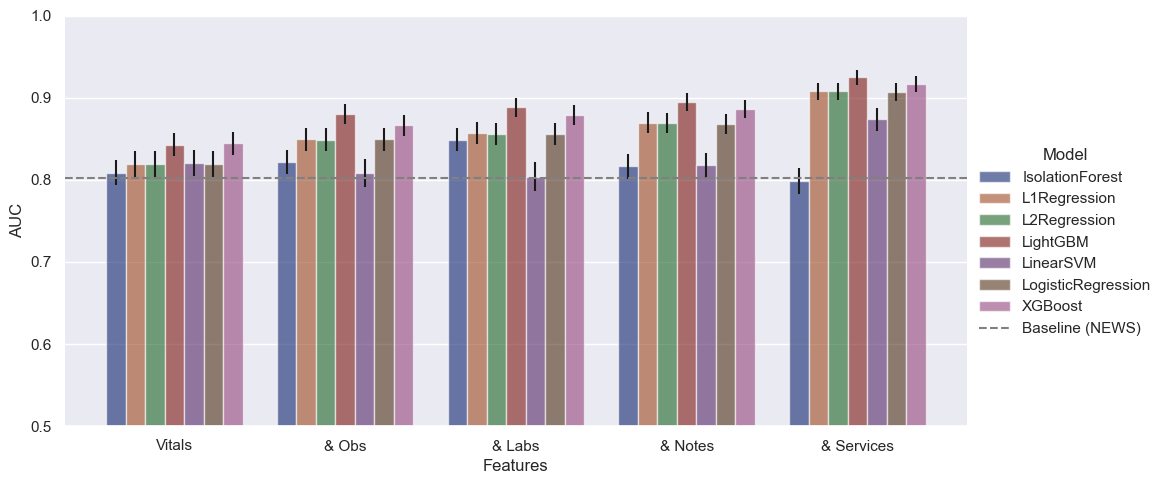

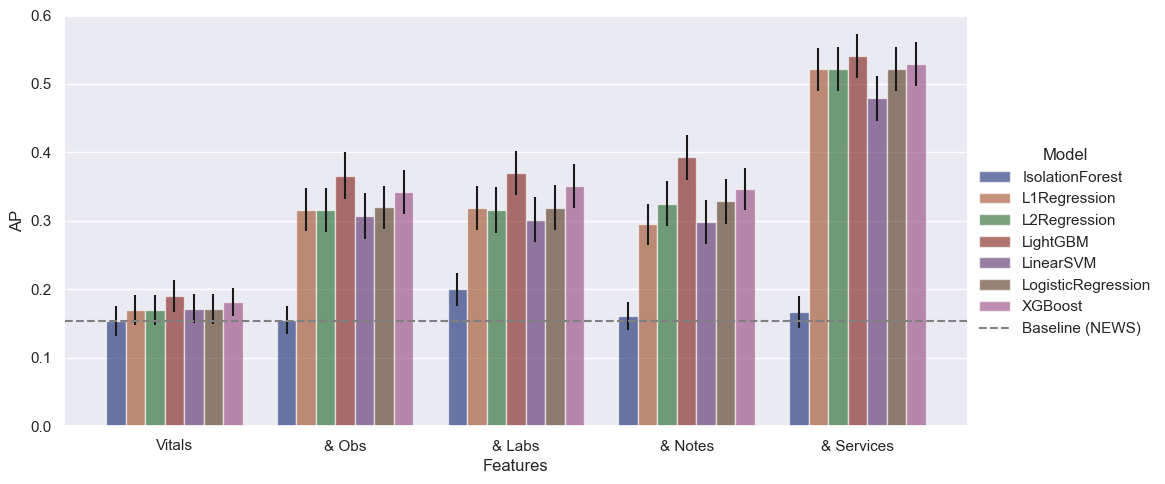

In [269]:
def select_feature_ablation_barplot(metrics, feature_groups, metric='AUC', ylim=(0.0, 1.0), baseline=None, save=None):
    sns.set_style('darkgrid')
    df = metrics[
        (metrics.features.isin(feature_groups.keys()))
        & (metrics.resampler == 'None')
    ].rename(columns=dict(
        features='Features',
        estimator='Model'
    ))
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df['Features'] = df.Features.replace(feature_groups)
    g = sns.catplot(
        data=df, x='Features', y=metric, hue='Model',
        kind='bar', palette='dark', alpha=.6, height=6, orient='v', legend=False
    )
    g.despine(left=True)
    g.fig.set_size_inches(10,5)
    g.ax.set_ylim(ylim)
    x_coords = [p.get_x() + 0.5*p.get_width() for p in g.ax.patches]
    y_coords = [p.get_height() for p in g.ax.patches]
    g.ax.errorbar(x=x_coords, y=y_coords, yerr=err, fmt="none", c= "k")

    if baseline is not None:
        g.refline(y = baseline[metric], color = 'gray', linestyle = '--', label = "Baseline (NEWS)") 
        g.add_legend(title='Model')
    
    if save:
        plt.savefig(save, bbox_inches="tight", dpi=100)

select_feature_ablation_barplot(METRICS, select_feature_groups, 'AUC', (0.5, 1.0), baseline=baseline_news_performance, save=f'{Notebook.IMAGE_DIR}/auc_bar.png')
select_feature_ablation_barplot(METRICS, select_feature_groups, 'AP', (0.0, 0.6), baseline=baseline_news_performance, save=f'{Notebook.IMAGE_DIR}/ap_bar.png')

### Precision-Recall

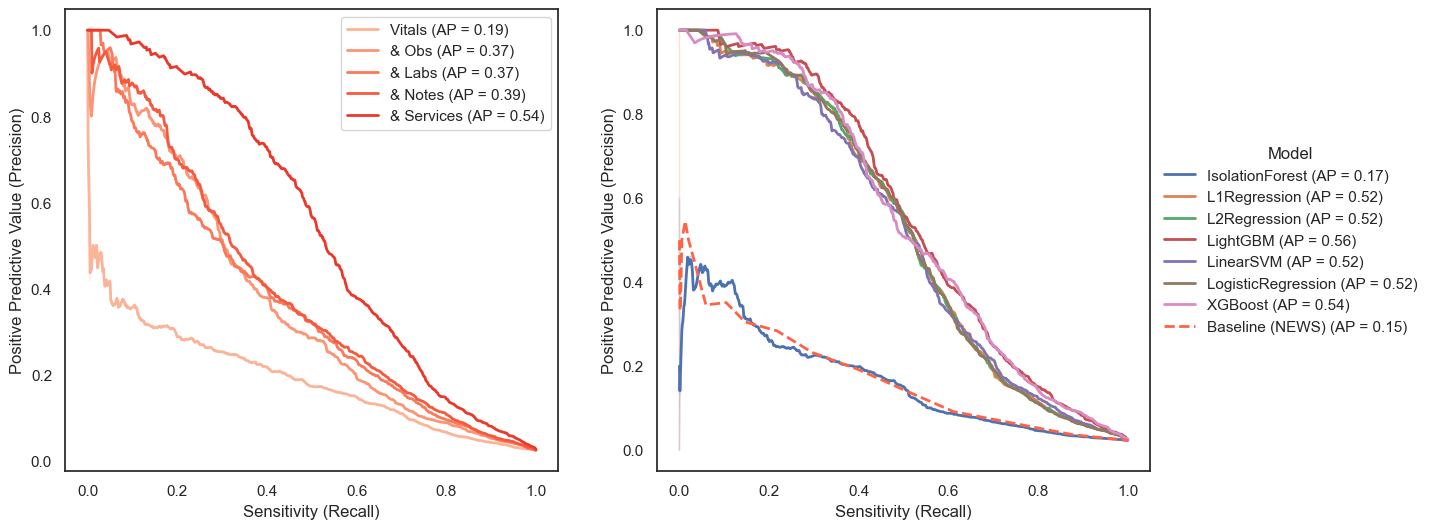

In [271]:
def pr_curves_for_paper(metrics, y_preds, save=None):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.set_style("white")
    
    metrics_l = metrics[(metrics.estimator == 'LightGBM') & (metrics.features.isin(select_feature_groups.keys())) & (metrics.resampler == 'None') & (metrics.outcome_within == 1)]
    metrics_r = metrics.loc[
        metrics[(metrics.features=='with_notes_labs_and_hospital') & (metrics.outcome_within==1)].groupby('estimator').AP.idxmax()
    ]
    
    y_preds_l = y_preds[metrics_l.name]
    y_preds_l.columns=metrics_l.features.replace(select_feature_groups)
    y_preds_l = y_preds_l.to_dict(orient='list')
    
    y_preds_r = y_preds[metrics_r.name]
    y_preds_r.columns=metrics_r.estimator
    y_preds_r = y_preds_r.to_dict(orient='list') | {'Baseline (NEWS)': sci_test.NEWS_score}
    
    y_test = sci_test.derive_critical_event(within=1, return_series=True)
    
    plot_pr_curves(y_test, y_preds_l, smoothing=True, ax=ax[0], palette=sns.color_palette('Reds', 10)[2:], title=None)
    plot_pr_curves(y_test, y_preds_r, smoothing=True, ax=ax[1], title=None, baseline_key='Baseline (NEWS)')

    sns.move_legend(ax[1], "center left", bbox_to_anchor=(1, 0.5), frameon=False, title='Model')

    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')
    

pr_curves_for_paper(METRICS, Y_PREDS, save=f'{Notebook.IMAGE_DIR}/pr_curves.svg')

## LR Coefficients

In [272]:
from utils.evaluation import get_calibrated_regression_coefficients, regression_coefficient_sorted_barplot
def get_coefficients(name, onehot_cols=None):
    if onehot_cols is None:
        X_train, X_test, y_train, y_test = get_xy(scii, Estimator_L1Regression, scii.feature_group_combinations['with_notes_labs_and_hospital'])
        onehot_cols = X_train.get_onehot_categorical_columns()
    
    model, _, _ = load_model(name, Notebook.SYS_RESULTS_DIR)
    coef = get_calibrated_regression_coefficients(model, model.feature_names_in_, name.split('_')[0])

    coef_num = coef[~coef.Feature.isin([__ for _ in onehot_cols.values() for __ in _])].sort_values('Coefficient')
    coef_cat = {k: coef[coef.Feature.isin(v)].sort_values('Coefficient') for k, v in onehot_cols.items()}

    return coef_num, coef_cat


#coef_num, coef_cat = get_coefficients('L1Regression_None_Within-1_with_notes_labs_and_hospital')

In [274]:
from systematic_comparison import PipelineFactory
X_train, X_test, y_train, y_test = get_xy(scii, Estimator_LogisticRegression, scii.feature_group_combinations['with_notes_labs_and_hospital'])

TypeError: __init__() missing 1 required positional argument: 'y_train'

In [273]:
def numerical_coefficient_table(estimators=['LogisticRegression', 'L1Regression', 'L2Regression'], feature_group='with_notes_labs_and_hospital'):
    X_train, X_test, y_train, y_test = get_xy(scii, Estimator_L1Regression, scii.feature_group_combinations['with_notes_labs_and_hospital'])
    onehot_cols = X_train.get_onehot_categorical_columns()

    return pd.concat((
        (
            get_coefficients(f'{_}_None_Within-1_{feature_group}', onehot_cols)[0]
            .set_index('Feature').Coefficient.rename(_)
        ) for _ in estimators), axis=1
    ).round(4).T

numerical_coefficient_table()

Feature,SentToSDEC,AVCPU_Alert,Female,VomitingSinceLastRound,Readmission,O2_saturation,Age,DiastolicBP,Sodium_serum,SystolicBP,Creatinine,Haemoglobin,HeartRate,Urea_serum,Potassium_serum,Temperature,Respiration_rate,Pain,LyingDown,Nausea,Oxygen_flow_rate,AssistedBreathing
LogisticRegression,-1.1087,-0.8141,-0.1949,-0.1724,-0.0989,-0.0641,-0.0200,-0.0095,-0.0089,-0.0016,-0.0000,0.0014,0.0072,0.0452,0.0677,0.0706,0.0789,0.1801,0.3172,0.3657,0.8646,1.4636
L1Regression,-1.0882,-0.0325,0.2702,0.1892,-0.1065,-0.1979,-0.5415,0.1052,-0.8010,-0.0244,-0.1805,0.1462,0.1202,-0.0030,0.4412,-0.0510,0.1975,0.0793,0.3332,0.0735,-0.4395,-0.1249
L2Regression,-1.1062,-0.8046,-0.1866,-0.1307,-0.0923,-0.0657,-0.0203,-0.0092,-0.0089,-0.0016,-0.0001,0.0015,0.0068,0.0471,0.0651,0.0793,0.0781,0.1830,0.3199,0.3479,0.8325,1.4344


## SHAP

In [132]:
from utils.evaluation import plot_shap_features_joint, plot_calibrated_regression_coefficients

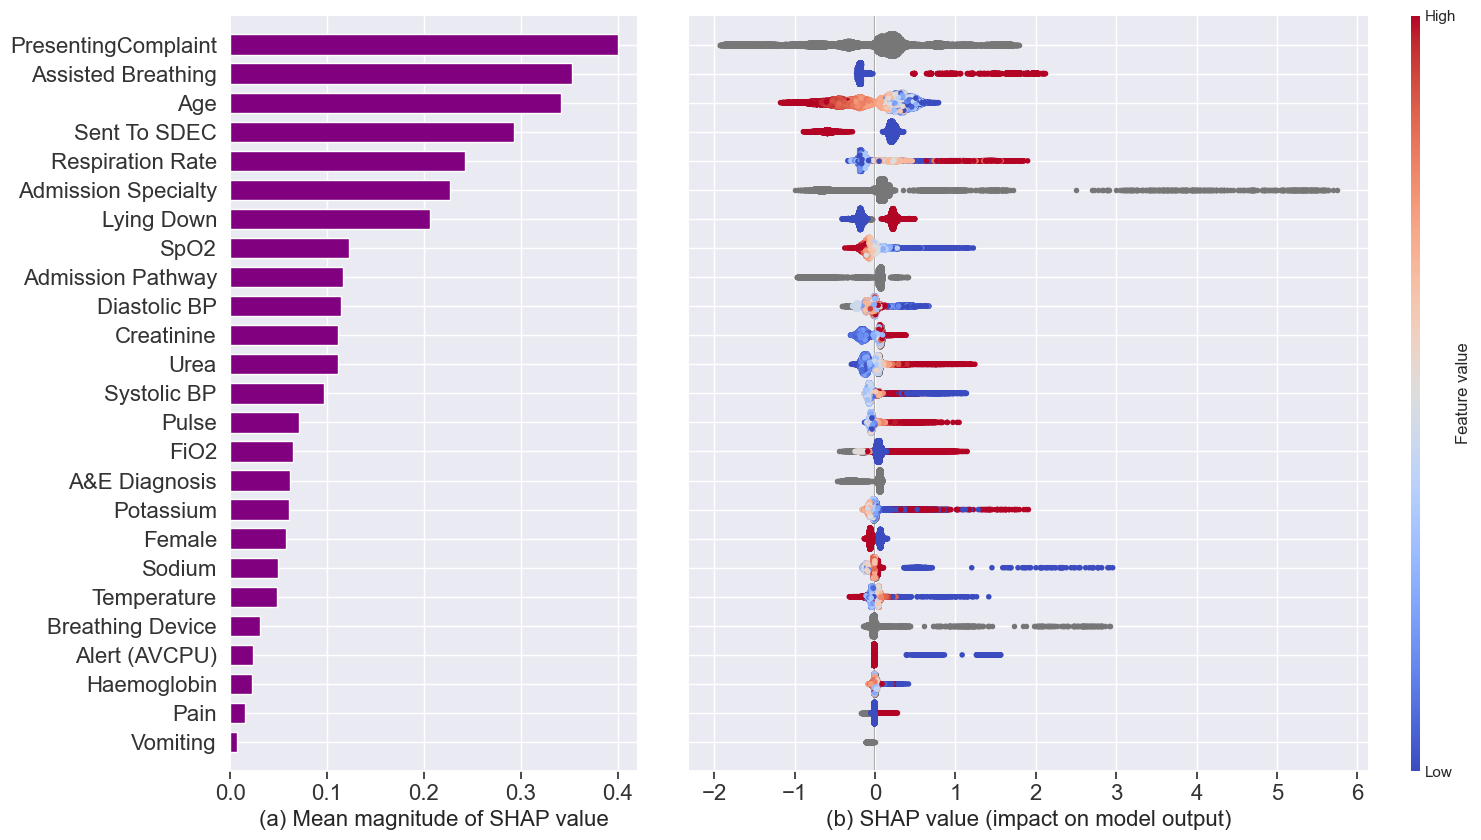

In [151]:
def lgbm_explanations()
    _, explanations, _ = load_model('LightGBM_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)
    explanations.feature_names = list(map(SCICols.pretty_print_columns.get, explanations.feature_names))
    plot_shap_features_joint(
        explanations, 
        max_display=25,
        figsize=(16, 9),
        wspace=-0.2,
        bar_aspect=0.03,
        topadjust=0.925,
        save=f'{Notebook.IMAGE_DIR}/shap_lgbm.png'
    )
    
lgbm_explanations()

In [166]:
_, explanations, _ = load_model('LightGBM_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)
categories =scii.omit_redundant().categorize().describe_categories()[1]

13

In [229]:
explanations.feature_names.index('AandEPresentingComplaint')

14

In [244]:
df = pd.DataFrame(zip(explanations[:, 14].values, explanations[:, 14].data), columns=['Value', 'Data']).pivot(columns='Data').Value
selected = df.apply(abs).mean().sort_values().tail(10).index
df.mean().loc[selected].sort_values()

Data
back pain         -1.687930
facial problems   -1.598557
chest infection   -1.382617
mental illness    -1.362497
testicular pain   -1.176756
pneumonia         -1.142528
abnormal bloods   -1.131595
uti                1.126933
diabetes           1.523134
gi bleeding        1.561843
dtype: float64

In [245]:
cat = shap.Explanation(
    values=df[selected].values,
    data=df[selected].fillna(0).values/df[selected].fillna(1).values,
    base_values=explanations.base_values[:len(selected)],
    feature_names=selected
)

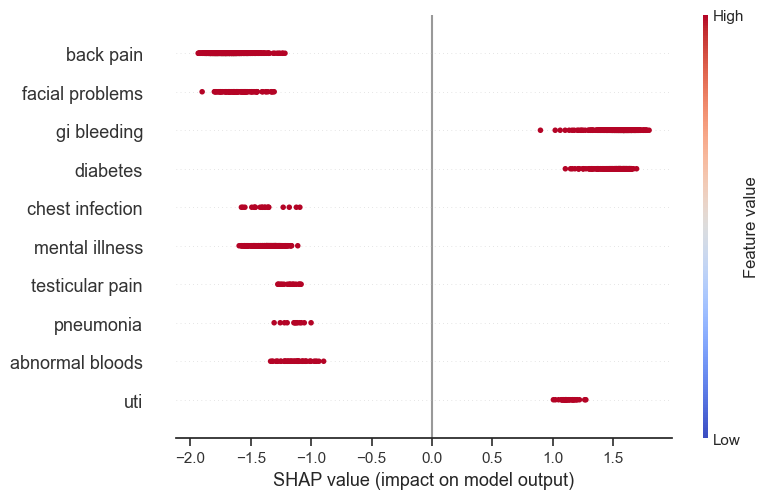

In [248]:
shap.plots.beeswarm(
    cat,
    max_display=25,
    show=False,
    color=plt.get_cmap("coolwarm")
)